In [62]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression


In [2]:
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

## Exercise 2

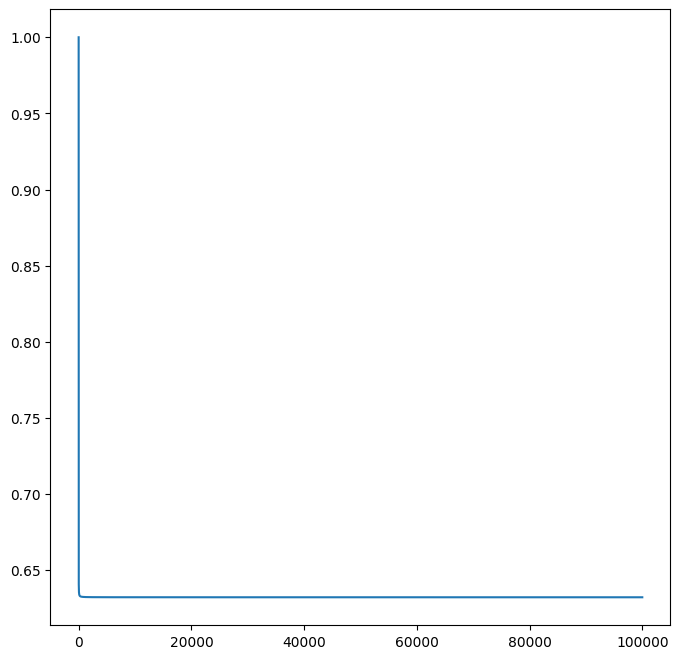

In [2]:
ax = subplots(figsize=(8,8))[1] 
A=np.arange(1,100000)
ax.plot(A, 1-(1-1/A)**A) #converges to 1-e^(-1) 

In [14]:
rng = np.random.default_rng (10)
store = np.empty (10000)
for i in range (10000):
    store[i] = np.sum(rng.choice(100, size=100, replace=True) == 4) > 0
np.mean(store) # we are close to the value 1-e^(-1)

0.6362

## Exercise 5

In [49]:
Default=load_data("Default")
Default["student1"]=Default.student=="Yes"
Default

,default,student,balance,income,student1
0,No,No,729.526495,44361.625074,False
1,No,Yes,817.180407,12106.134700,True
2,No,No,1073.549164,31767.138947,False
3,No,No,529.250605,35704.493935,False
4,No,No,785.655883,38463.495879,False
...,...,...,...,...,...
9995,No,No,711.555020,52992.378914,False
9996,No,No,757.962918,19660.721768,False
9997,No,No,845.411989,58636.156984,False
9998,No,No,1569.009053,36669.112365,False


In [50]:
x=Default[['balance','income']]
x2=Default[['balance','income','student1']]

In [11]:
y=Default.default

In [36]:
(x_train,
 x_test,
 y_train,
 y_test) = train_test_split(x,
                            y,
                            test_size=0.5,
                            random_state=1)

In [42]:
for i in range(4):
    (x_train,
     x_test,
     y_train,
     y_test) = train_test_split(x,
                                y,
                                test_size=0.5,
                                random_state=i)
    Log = LogisticRegression() 
    Log.fit(x_train,y_train) 
    results=Log.predict(x_test) #Default threshold is 0.5, we can access the probabilities via Log.predict_proba(x_test)  
    print(np.mean(results!=y_test))

0.029
0.025
0.0248
0.0248


In [51]:
for i in range(4):
    (x_train,
     x_test,
     y_train,
     y_test) = train_test_split(x2,
                                y,
                                test_size=0.5,
                                random_state=i)
    Log = LogisticRegression() 
    Log.fit(x_train,y_train) 
    results=Log.predict(x_test) 
    print(np.mean(results!=y_test))

0.0294
0.0262
0.025
0.0252


In [52]:
#The results are similar with or without the student variable

## Exercise 6

In [67]:
xc=sm.add_constant(x)
y2=y=="Yes"
glm = sm.GLM(y2,  xc,family=sm.families.Binomial())
results = glm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Fri, 17 May 2024   Deviance:                       1579.0
Time:                        11:46:50   Pearson chi2:                 6.95e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1256
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================
"""

In [85]:
def boot_fn(df,idx):
    x3=sm.add_constant(Default[['income','balance']].iloc[idx])
    y3=y.iloc[idx]=="Yes"
    glm = sm.GLM(y3,  x3,family=sm.families.Binomial())
    results = glm.fit()
    return results.params
    
    

In [115]:
def indexes_gen(i):
    rng = np.random.default_rng(i)
    return(rng.choice(Default.shape[0],Default.shape[0],replace=True))

In [136]:
estimate1=1000*[0]
estimate0=1000*[0]
estimate2=1000*[0]
for i in range(1000):
    I=indexes_gen(i)
    estimate0[i],estimate1[i],estimate2[i]=boot_fn(Default,I)
    


In [137]:
np.mean(estimate0)

-11.599221788148165

In [138]:
np.sqrt(sum((np.asarray(estimate0)-np.mean(estimate0))**2)/(1000-1))

0.4409865570124455

In [139]:
np.mean(estimate1)

2.1092285173232834e-05

In [140]:
np.sqrt(sum((np.asarray(estimate1)-np.mean(estimate1))**2)/(1000-1))

4.838978962543956e-06

In [141]:
np.mean(estimate2)

0.00567535063845724

In [142]:
np.sqrt(sum((np.asarray(estimate2)-np.mean(estimate2))**2)/(1000-1))

0.00023113065539271955

In [143]:
#The results are pretty similar

## Exercise 7

In [144]:
Weekly=load_data("Weekly")

In [160]:
x=Weekly[["Lag1","Lag2"]]
y=Weekly.Direction

In [156]:
Log = LogisticRegression() #Acces coefficients with Log.coef_ and Log.intercept_: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
Log.fit(x,y) 
print(Log.intercept_,Log.coef_)

[0.22122423] [[-0.03869725  0.06020635]]


In [165]:
x2=Weekly[["Lag1","Lag2"]].iloc[1:]
y2=Weekly.Direction.iloc[1:]

In [166]:
Log2 = LogisticRegression() 
Log2.fit(x2,y2) 
print(Log2.intercept_,Log2.coef_)

[0.22324303] [[-0.03840843  0.06080518]]


In [184]:
Log2.predict(x.loc[0:0])

array(['Up'], dtype=object)

In [189]:
Weekly.loc[0].Direction #The observation is not correctly classified

'Down'

In [203]:
results=[]
for i in range(1089):
    xi=x.drop(index=i)
    yi=y.drop(index=i)
    Logi = LogisticRegression() 
    Logi.fit(xi,yi) 
    res=Logi.predict(x.loc[i:i])
    results.append((res==y.loc[i])[0])
    
    
    

In [206]:
np.mean(results) #The LOOCV is about 45%, almost the same as what we did in Chapter 4

0.5500459136822773

## Exercise 8

In [4]:
rng = np.random.default_rng (1)
x = rng.normal(size =100)
y = x - 2 * x**2 + rng.normal(size =100) #n=100, p=1. y=f(x)+eps=x-2x^2+eps

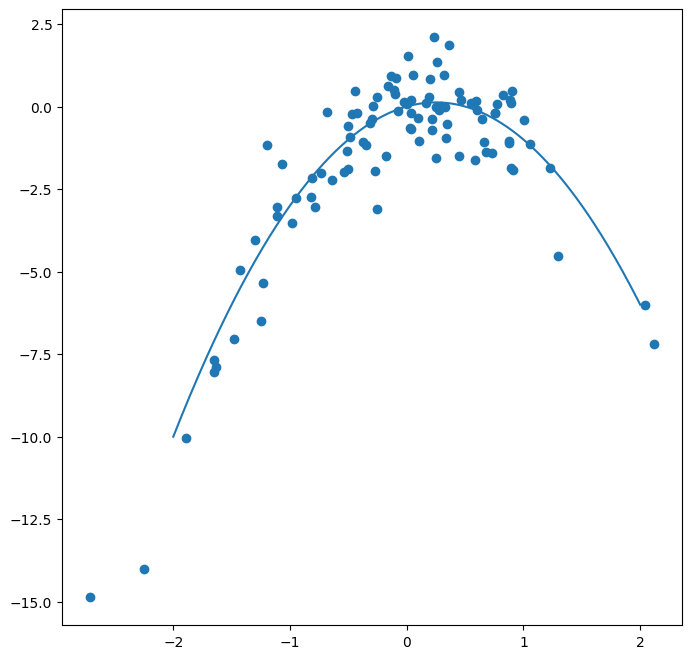

In [11]:
ax = subplots(figsize=(8,8))[1] 
ax.scatter(x,y);
x2 = np.linspace(-2, 2, 400) 
y2= x2 - 2 * x2**2
ax.plot(x2,y2);

In [75]:
df=pd.DataFrame({'X': x, 'Y': y})
df['X2']=df['X']**2
df['X3']=df['X']**3
df['X4']=df['X']**4

In [71]:
resultslist=[]
x=df['X']
y=df['Y']
for i in range(100):
    xi=x.drop(index=i)
    yi=y.drop(index=i)
    LR=LinearRegression()
    LR.fit(xi.to_frame(),yi.to_frame()) 
    res=LR.predict(x.loc[i:i].to_frame())[0]
    resultslist.append(((res-y.loc[i])[0])**2)
np.mean(resultslist)

6.633029839181983

In [78]:
resultslist=[]
x=df[['X','X2']]
y=df['Y']
for i in range(100):
    xi=x.drop(index=i)
    yi=y.drop(index=i)
    LR=LinearRegression()
    LR.fit(xi,yi.to_frame()) 
    res=LR.predict(x.loc[i:i])[0]
    resultslist.append(((res-y.loc[i])[0])**2)
np.mean(resultslist)

1.1229368563419677

In [79]:
resultslist=[]
x=df[['X','X2','X3']]
y=df['Y']
for i in range(100):
    xi=x.drop(index=i)
    yi=y.drop(index=i)
    LR=LinearRegression()
    LR.fit(xi,yi.to_frame()) 
    res=LR.predict(x.loc[i:i])[0]
    resultslist.append(((res-y.loc[i])[0])**2)
np.mean(resultslist)

1.3017965489358883

In [80]:
resultslist=[]
x=df[['X','X2','X3','X4']]
y=df['Y']
for i in range(100):
    xi=x.drop(index=i)
    yi=y.drop(index=i)
    LR=LinearRegression()
    LR.fit(xi,yi.to_frame()) 
    res=LR.predict(x.loc[i:i])[0]
    resultslist.append(((res-y.loc[i])[0])**2)
np.mean(resultslist)

1.3323942694179352

In [81]:
rng = np.random.default_rng (34)
x = rng.normal(size =100)
y = x - 2 * x**2 + rng.normal(size =100)

In [82]:
df=pd.DataFrame({'X': x, 'Y': y})
df['X2']=df['X']**2
df['X3']=df['X']**3
df['X4']=df['X']**4

In [83]:
resultslist=[]
x=df['X']
y=df['Y']
for i in range(100):
    xi=x.drop(index=i)
    yi=y.drop(index=i)
    LR=LinearRegression()
    LR.fit(xi.to_frame(),yi.to_frame()) 
    res=LR.predict(x.loc[i:i].to_frame())[0]
    resultslist.append(((res-y.loc[i])[0])**2)
np.mean(resultslist)

6.692400483962456

In [84]:
resultslist=[]
x=df[['X','X2']]
y=df['Y']
for i in range(100):
    xi=x.drop(index=i)
    yi=y.drop(index=i)
    LR=LinearRegression()
    LR.fit(xi,yi.to_frame()) 
    res=LR.predict(x.loc[i:i])[0]
    resultslist.append(((res-y.loc[i])[0])**2)
np.mean(resultslist)

0.9894344715661427

In [89]:
resultslist=[]
x=df[['X','X2','X3']]
y=df['Y']
for i in range(100):
    xi=x.drop(index=i)
    yi=y.drop(index=i)
    LR=LinearRegression()
    a=LR.fit(xi,yi.to_frame()) 
    res=LR.predict(x.loc[i:i])[0]
    resultslist.append(((res-y.loc[i])[0])**2)
np.mean(resultslist)

1.0922044798083757

In [95]:
resultslist=[]
x=df[['X','X2','X3','X4']]
y=df['Y']
for i in range(100):
    xi=x.drop(index=i)
    yi=y.drop(index=i)
    LR=LinearRegression()
    LR.fit(xi,yi.to_frame()) 
    res=LR.predict(x.loc[i:i])[0]
    resultslist.append(((res-y.loc[i])[0])**2)
np.mean(resultslist)


1.044182309352764

In [87]:
#The results are similar but different because of the variance

In [96]:
#Best model is the one of degree 2 because it matches the true behavior of f(X). 

In [98]:
#We don't have p-values with scikit-learn but the p values for x^3 and x^4 would probably be high

## Exercise 9

In [100]:
Boston=load_data("Boston")

In [106]:
muhat=np.mean(Boston.medv)

In [110]:
semuhat=np.std(Boston.medv)/np.sqrt(506)
semuhat

0.4084569346972866

In [121]:
def boot_fn(df,idx):
    return np.mean(Boston.medv[idx])

def indexes_gen(i):
    rng = np.random.default_rng(i)
    return(rng.choice(Boston.shape[0],Boston.shape[0],replace=True))

In [127]:
boot=1000*[0]
for i in range(1000):
    boot[i]=boot_fn(Boston,indexes_gen(i))

In [135]:
semuhat2=np.sqrt(sum((boot-np.mean(boot))**2)/999) #The results are very similar
semuhat2

0.4066033818051004

In [137]:
(muhat-2*semuhat2,muhat+2*semuhat2)

(21.719599560500477, 23.346013087720877)

In [143]:
mumedhat=np.median(Boston.medv)
mumedhat

21.2

In [144]:
def boot_fn2(df,idx):
    return np.median(Boston.medv[idx])

boot=1000*[0]
for i in range(1000):
    boot[i]=boot_fn2(Boston,indexes_gen(i))

In [146]:
mumedhat2=np.sqrt(sum((boot-np.mean(boot))**2)/999)
mumedhat2 #The result is similar to semuhat2

0.37493315720588377

In [147]:
percent=np.percentile(Boston.medv,10)
percent

12.75

In [150]:
def boot_fn3(df,idx):
    return np.percentile(Boston.medv[idx],10)

boot=1000*[0]
for i in range(1000):
    boot[i]=boot_fn3(Boston,indexes_gen(i))

In [151]:
sepercent=np.sqrt(sum((boot-np.mean(boot))**2)/999)
sepercent

0.5209520020966313